In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot
%matplotlib inline
plt.style.use('ggplot')

from plotly.subplots import make_subplots
import plotly.graph_objs as go
import re


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Final_Clean_1.csv')
print(df.shape)
df.head(3)

(833852, 4)


raw_sentence  \
0  subsection retarded Hungarians Ohh boy brace l...   
1  yall hear sumn mean live small town rn work pe...   
2  Japanese arent retarded know fictional charact...   

                             clean_sentence_training  \
0  subsection retard hungarian boy brace livid bu...   
1  hear sumn mean live small town work people ori...   
2  retarded know fictional character owe dignity ...   

                                  clean_sentence_EDA  label  
0  subsection retard hungarian boy brace livid bu...      0  
1  hear sumn mean live small town work people ori...      0  
2  retarded know fictional character owe dignity ...      1

In [3]:
df.dropna(inplace=True)
df.shape

(819438, 4)

In [4]:
df.isnull().sum()

raw_sentence               0
clean_sentence_training    0
clean_sentence_EDA         0
label                      0
dtype: int64

## Info
+ label == 0 - Not Hateful/ Non-Risky
+ label == 1 - offensive / potentially_risky 
+ label == 2 - hateful / Risky

In [5]:
df_hate = df[df["label"] == 2]
df_potentially_risky = df[df["label"] == 1 ]
df_nonhate = df[df["label"] == 0 ]

df_hate.reset_index(inplace=True, drop=True)
df_potentially_risky.reset_index(inplace=True, drop=True)
df_nonhate.reset_index(inplace=True, drop=True)

df_hate.shape, df_potentially_risky.shape, df_nonhate.shape

((68022, 4), (152573, 4), (598843, 4))

In [6]:
fig=make_subplots(subplot_titles=('DataSet Overview',))
x=df["label"].value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C', '#fc03ca', '#03a1fc'],name='train'))

# 1-a
# Unigram

In [7]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_grams(corpus, ngram_range=(1,1), nbwords=10):
    vect = CountVectorizer(ngram_range=ngram_range, dtype=np.dtype('int8'))
    counts = vect.fit_transform(corpus).toarray().sum(axis=0)
    
    # Sort the index of the nbwords most frequent words (note : argsort() is an ascending sort)
    argsort_descending = counts.argsort()[::-1][:nbwords]
    names = np.array(vect.get_feature_names())[argsort_descending]
    counts_sorted = counts[argsort_descending]
    return names, counts_sorted

def plot_bar(names, counts_sorted, color_groups, title):
    fig = go.Figure(go.Bar(x=counts_sorted, 
                           y=names,
                           orientation='h',
                           marker_color = ['#097394']*color_groups[0] + ['#52B1CE']*color_groups[1] + ['#A8E0F2']*color_groups[2]),
                   )
    
    fig.update_traces(marker_line_color = '#077092', opacity=0.8)
    fig['layout']['yaxis']['autorange'] = "reversed"
    
    fig.update_layout(title=title)
    fig.show()

In [8]:
nb_words = 15
names, counts = get_top_grams(df_hate["clean_sentence_EDA"], ngram_range=(1,1), nbwords=nb_words)
plot_bar(names, counts, (1,4,nb_words), f"Top {nb_words} <b>Unigram from Risky Dataset<b>")

In [9]:
nb_words = 15
names, counts = get_top_grams(df_potentially_risky["clean_sentence_EDA"], ngram_range=(1,1), nbwords=nb_words)
plot_bar(names, counts, (1,4,nb_words), f"Top {nb_words} <b>Unigram from Potentially Risky Dataset<b>")

In [10]:
nb_words = 15
names, counts = get_top_grams(df_nonhate["clean_sentence_EDA"][:150000], ngram_range=(1,1), nbwords=nb_words)
plot_bar(names, counts, (1,4,nb_words), f"Top {nb_words} <b>Unigram from Non Risky Dataset<b>")

# 1-b
# Bigram

In [11]:
nb_words = 15
names, counts = get_top_grams(df_hate["clean_sentence_EDA"][:50000], ngram_range=(2,2), nbwords=nb_words)
plot_bar(names, counts, (1,4,nb_words), f"Top {nb_words} <b>Bigram from Risky Dataset<b>")

In [12]:
nb_words = 15
names, counts = get_top_grams(df_potentially_risky["clean_sentence_EDA"][:50000], ngram_range=(2,2), nbwords=nb_words)
plot_bar(names, counts, (1,4,nb_words), f"Top {nb_words} <b>Bigram from Potentialy Risky Dataset<b>")

In [14]:
nb_words = 15
names, counts = get_top_grams(df_nonhate["clean_sentence_EDA"][:50000], ngram_range=(2,2), nbwords=nb_words)
plot_bar(names, counts, (1,4,nb_words), f"Top {nb_words} <b>Bigram from Non Risky Dataset<b>")

# 2

In [15]:
import gensim
from gensim.corpora import Dictionary

In [16]:
def tokenization(texts):
    for text in texts:
        yield(gensim.utils.simple_preprocess(str(text)))  # deacc=True removes punctuations

# List of tokenized texts
data_words = list(tokenization(df_hate['clean_sentence_EDA']))
print("Tokenization of the first text :",data_words[2])

# Create Dictionary
id2word = Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print("and his Term Document Frequency :",corpus[2])   # Select 2nd corpus

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[2:3]]

Tokenization of the first text : ['cop', 'fuck', 'retarded', 'cunt']
and his Term Document Frequency : [(4, 1), (5, 1), (6, 1), (7, 1)]


[[('cop', 1), ('cunt', 1), ('fuck', 1), ('retarded', 1)]]

In [17]:
print(df_hate.iloc[2])

raw_sentence               Everyone except cop fucking retarded cunt
clean_sentence_training                       cop fuck retarded cunt
clean_sentence_EDA                            cop fuck retarded cunt
label                                                              2
Name: 2, dtype: object


# 3

### Continuous Bag of Word (CBOW)

In [18]:
texts = [text.split() for text in df_hate["clean_sentence_EDA"]]

# We the the default configuration
w2v_cbow = gensim.models.word2vec.Word2Vec(sentences=texts,
                                        vector_size=300, window=5,     # here we train a cbow model 
                                        min_count=5,                      
                                        sample=0.001, workers=3,
                                        sg=0, hs=0, negative=5,        # set sg to 1 to train a sg model
                                        cbow_mean=1,
                                        epochs=30)

# print(w2v_cbow.wv.key_to_index) # get vocabulary

In [19]:
words = ['love', 'fuck', 'nigger']
n = 5
for word in words :
    print(f"Top {n} similar words with {word} :\n{w2v_cbow.wv.most_similar(word, topn=n)}\n\n")

Top 5 similar words with love :
[('adore', 0.3734283745288849), ('radicalise', 0.3715789318084717), ('hardworke', 0.37088194489479065), ('impolite', 0.36731117963790894), ('demise', 0.3578029274940491)]


Top 5 similar words with fuck :
[('ashol', 0.4173552095890045), ('thos', 0.401691198348999), ('shut', 0.3920224606990814), ('niggertard', 0.3724338412284851), ('shit', 0.3600640296936035)]


Top 5 similar words with nigger :
[('spic', 0.5370495915412903), ('cracker', 0.5359823107719421), ('rabble', 0.49007827043533325), ('nigga', 0.48673221468925476), ('black', 0.48396527767181396)]




In [20]:
texts = [text.split() for text in df_potentially_risky["clean_sentence_EDA"]]

# We the the default configuration
w2v_cbow = gensim.models.word2vec.Word2Vec(sentences=texts,
                                        vector_size=300, window=5,     # here we train a cbow model 
                                        min_count=5,                      
                                        sample=0.001, workers=3,
                                        sg=0, hs=0, negative=5,        # set sg to 1 to train a sg model
                                        cbow_mean=1,
                                        epochs=30)

# print(w2v_cbow.wv.key_to_index) # get vocabulary

In [21]:
words = ['love', 'fuck', 'nigger']
n = 5
for word in words :
    print(f"Top {n} similar words with {word} :\n{w2v_cbow.wv.most_similar(word, topn=n)}\n\n")

Top 5 similar words with love :
[('flatmate', 0.31370508670806885), ('awesome', 0.2941019833087921), ('adore', 0.29232698678970337), ('hate', 0.29026180505752563), ('awsome', 0.28208309412002563)]


Top 5 similar words with fuck :
[('fucking', 0.5384678840637207), ('shit', 0.4945164620876312), ('bitch', 0.4527292251586914), ('motherfucker', 0.4193982779979706), ('ass', 0.3883260488510132)]


Top 5 similar words with nigger :
[('spic', 0.4487854540348053), ('cracker', 0.40193885564804077), ('sand', 0.3889618515968323), ('ape', 0.3771190941333771), ('chink', 0.3703433573246002)]




In [22]:
texts = [text.split() for text in df_nonhate["clean_sentence_EDA"]]

# We the the default configuration
w2v_cbow = gensim.models.word2vec.Word2Vec(sentences=texts,
                                        vector_size=300, window=5,     # here we train a cbow model 
                                        min_count=5,                      
                                        sample=0.001, workers=3,
                                        sg=0, hs=0, negative=5,        # set sg to 1 to train a sg model
                                        cbow_mean=1,
                                        epochs=30)

# print(w2v_cbow.wv.key_to_index) # get vocabulary

In [23]:
words = ['love', 'fuck', 'nigger']
n = 5
for word in words :
    print(f"Top {n} similar words with {word} :\n{w2v_cbow.wv.most_similar(word, topn=n)}\n\n")

Top 5 similar words with love :
[('amazing', 0.5026246309280396), ('awesome', 0.4982970654964447), ('cute', 0.47680696845054626), ('hate', 0.47590428590774536), ('beautiful', 0.4713643193244934)]


Top 5 similar words with fuck :
[('fucking', 0.7349229454994202), ('shit', 0.6775670051574707), ('bitch', 0.6192960143089294), ('faggot', 0.5936790704727173), ('dude', 0.5769011974334717)]


Top 5 similar words with nigger :
[('fuck', 0.5550642609596252), ('faggot', 0.5500940680503845), ('bitch', 0.5040660500526428), ('sheboon', 0.4997725784778595), ('white', 0.482253760099411)]




# 4

### Skip-Gram(SG)

In [24]:
texts = [text.split() for text in df_hate["clean_sentence_EDA"]]

w2v_sg = gensim.models.word2vec.Word2Vec(sentences=texts,
                                vector_size=300, window=5,               ### here we train a sg model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1,
                                epochs=30)

# print(w2v_sg.wv.key_to_index) # get vocabulary

**Most Similar Words**

In [25]:
words = ['love', 'fuck', 'nigger']
n = 5
for word in words :
    print(f"Top {n} similar words with {word} :\n{w2v_sg.wv.most_similar(word, topn=n)}\n\n")

Top 5 similar words with love :
[('radicalise', 0.45222511887550354), ('demise', 0.440926194190979), ('shamelessness', 0.4169217050075531), ('hardworke', 0.4121875762939453), ('impolite', 0.41209420561790466)]


Top 5 similar words with fuck :
[('niggertard', 0.5139989256858826), ('troute', 0.5096235871315002), ('ashol', 0.5039175152778625), ('ass', 0.49853482842445374), ('wheelchairi', 0.47602128982543945)]


Top 5 similar words with nigger :
[('rabble', 0.5625754594802856), ('nickel', 0.5334267616271973), ('honkie', 0.5071903467178345), ('alex', 0.5038036704063416), ('centraliststupid', 0.49663111567497253)]




# 5

# Word Cloud

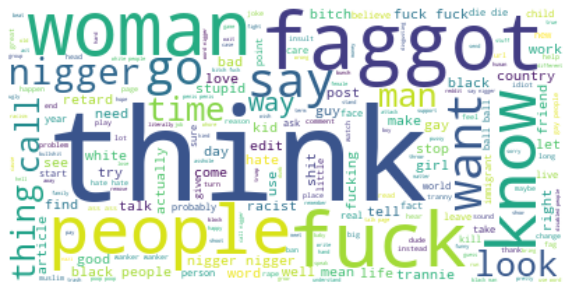

In [26]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

def generate_wordcloud(df,title):
    
    text = " ".join(i for i in df["clean_sentence_EDA"])
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
generate_wordcloud(df_hate, 'clean_sentence_EDA')

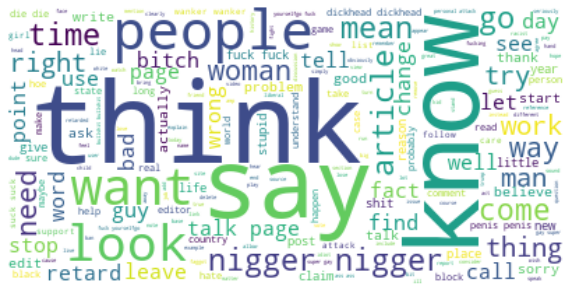

In [27]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

def generate_wordcloud(df,title):
    
    text = " ".join(i for i in df["clean_sentence_EDA"])
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
generate_wordcloud(df_potentially_risky, 'clean_sentence_EDA')

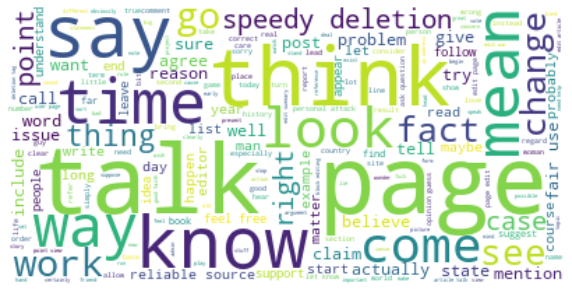

In [28]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

def generate_wordcloud(df,title):
    
    text = " ".join(i for i in df["clean_sentence_EDA"])
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
generate_wordcloud(df_nonhate, 'clean_sentence_EDA')

# 6
# Unique Word Count

In [29]:
uniqueWords_hate = list(set(" ".join(df_hate["clean_sentence_EDA"] ).lower().split(" ")))
count_hate = len(uniqueWords_hate)

uniqueWords_potentially_risky = list(set(" ".join(df_potentially_risky["clean_sentence_EDA"] ).lower().split(" ")))
count_potentially_risky = len(uniqueWords_potentially_risky)

uniqueWords_nonhate = list(set(" ".join(df_nonhate["clean_sentence_EDA"] ).lower().split(" ")))
count_nonhate = len(uniqueWords_nonhate)

In [30]:
data = np.array([count_hate, count_potentially_risky, count_nonhate ])
ser = pd.Series(data, index=['risky', 'potentially_risky', 'non_risky' ])

fig=make_subplots(subplot_titles=('Unique Word Count', ))
x=ser
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C', '#fc03ca', '#03a1fc'],name='train'))